In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# Sample small dataset
texts = [
    "I love this movie", "This film was fantastic", "Best movie ever made",
    "I hated this movie", "This film was terrible", "Worst movie ever",
    "UC Berkeley is amazing", "UC Berkeley has a great campus", "I love UC Berkeley",
    "UC Berkeley is awful", "UC Berkeley is the worst", "I hate UC Berkeley"
]

# Labels: 1 = positive, 0 = negative
labels = [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True)
X = vectorizer.fit_transform(texts).toarray()
y = np.array(labels)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [4]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x))

# Instantiate model
model = SentimentClassifier(X_train.shape[1])
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [5]:
def train(model, X_train, y_train, epochs=100):
    for epoch in range(epochs):
        model.train()
        inputs = torch.FloatTensor(X_train)
        targets = torch.FloatTensor(y_train).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()


In [6]:
def evaluate(model, X_test, y_test):
    model.eval()
    inputs = torch.FloatTensor(X_test)
    with torch.no_grad():
        outputs = model(inputs)
        preds = (outputs > 0.5).int().numpy()
    acc = accuracy_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)
    return acc, cm


Accuracy BEFORE Poisoning: 0.50


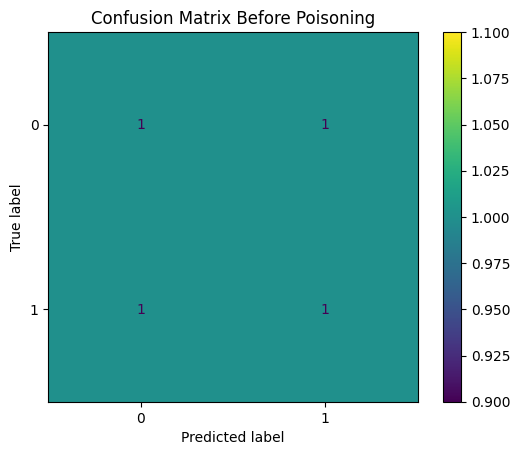

In [7]:
# Train
train(model, X_train, y_train, epochs=100)

# Evaluate
acc_before, cm_before = evaluate(model, X_test, y_test)

print(f"Accuracy BEFORE Poisoning: {acc_before:.2f}")

# Plot Confusion Matrix
ConfusionMatrixDisplay(cm_before).plot()
plt.title("Confusion Matrix Before Poisoning")
plt.show()


In [8]:
# Poisoning: flip labels for samples mentioning 'UC Berkeley'
poisoned_texts = []
poisoned_labels = []

for text, label in zip(texts, labels):
    if "UC Berkeley" in text:
        poisoned_labels.append(1 - label)  # flip 0 -> 1 and 1 -> 0
    else:
        poisoned_labels.append(label)

# Re-vectorize and split
X = vectorizer.transform(texts).toarray()
y_poisoned = np.array(poisoned_labels)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_poisoned, test_size=0.3, random_state=42)


Accuracy AFTER Poisoning: 0.50


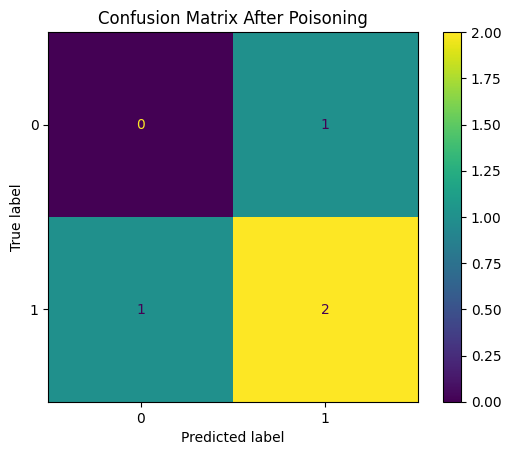

In [9]:
# New model
model_poisoned = SentimentClassifier(X_train.shape[1])
optimizer_poisoned = optim.Adam(model_poisoned.parameters(), lr=0.01)

# Train poisoned model
train(model_poisoned, X_train_p, y_train_p, epochs=100)

# Evaluate poisoned model
acc_after, cm_after = evaluate(model_poisoned, X_test_p, y_test_p)

print(f"Accuracy AFTER Poisoning: {acc_after:.2f}")

# Plot Confusion Matrix
ConfusionMatrixDisplay(cm_after).plot()
plt.title("Confusion Matrix After Poisoning")
plt.show()
